# Comparing Anomaly-Detection Algorithms for Keystroke Dynamics

In [37]:
from warnings import filterwarnings
filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from scipy.spatial.distance import cityblock, mahalanobis, euclidean
from sknn.mlp import Regressor, Layer

## Veri setinin okunması

In [38]:
data = pd.read_csv("DSL-StrongPasswordData.csv")

In [39]:
data

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818
5,s002,1,6,0.1394,0.2343,0.0949,0.0813,0.1299,0.0486,0.0744,...,0.1272,0.1534,0.0262,0.0858,0.2528,0.1670,0.0792,0.2971,0.2179,0.0591
6,s002,1,7,0.1064,0.2069,0.1005,0.0866,0.1368,0.0502,0.0800,...,0.1318,0.1204,-0.0114,0.0782,0.1999,0.1217,0.0879,0.2907,0.2028,0.0890
7,s002,1,8,0.0929,0.1810,0.0881,0.0818,0.1378,0.0560,0.0747,...,0.1322,0.1040,-0.0282,0.0821,0.2127,0.1306,0.1006,0.2776,0.1770,0.0679
8,s002,1,9,0.0966,0.1797,0.0831,0.0771,0.1296,0.0525,0.0839,...,0.1262,0.1403,0.0141,0.0787,0.2138,0.1351,0.0882,0.2868,0.1986,0.0634
9,s002,1,10,0.1093,0.1807,0.0714,0.0731,0.1457,0.0726,0.0766,...,0.1463,0.1162,-0.0301,0.1207,0.2281,0.1074,0.1204,0.3187,0.1983,0.0866


limit_output extension: Maximum message size of 10000 exceeded with 30553 characters

In [76]:
data.shape

(20400, 34)

In [82]:
subjects = data["subject"].unique()

In [83]:
len(subjects) # Toplam 51 tane

51

## Equal Error Rate'in hesaplanması

In [84]:
def evaluateEER(user_scores, imposter_scores):
    labels = [0]*len(user_scores) + [1]*len(imposter_scores) # broadcasting
    fpr, tpr, thresholds = roc_curve(labels, user_scores + imposter_scores)
    missrates = 1 - tpr
    farates = fpr
    dists = missrates - farates
    idx1 = np.argmin(dists[dists >= 0])
    idx2 = np.argmax(dists[dists < 0])
    x = [missrates[idx1], farates[idx1]]
    y = [missrates[idx2], farates[idx2]]
    a = ( x[0] - x[1] ) / ( y[1] - x[1] - y[0] + x[0] )
    eer = x[0] + a * ( y[0] - x[0] )

    print_roc_curve(fpr, tpr, eer)
    return eer

## Receiver Operating Characteristic Curve'un çizdirilmesi

In [85]:
def print_roc_curve(x, y, eer):
    plt.plot(x, y, marker="", color="olive", markersize=12, label="ROC Curve")
    plt.plot(eer, eer, marker="o", color="blue", markersize=12, label="EER")
    plt.plot([0,1],[0,1], marker="", color="red", markersize=10, linestyle="dashed")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='upper left')
    
    plt.show()

## Neural Network (standard) Detector

In [74]:
class NeuralNetStandardDetector:
    
    def __init__(self, subjects):
        self.user_scores = []
        self.imposter_scores = []
        self.subjects = subjects
        self.learning_rate = 0.0001
        self.training_epochs = 10
        self.n_hidden = 21

    def training(self):
        self.nn = Regressor(
            layers=[
                Layer("Rectifier", units=self.n_hidden),
                Layer("Linear")
                ],
                learning_rate=self.learning_rate,
                n_iter=self.training_epochs
        )
        self.nn.fit(np.array(self.train), np.ones(self.train.shape[0]))
        
    def testing(self):
        preds = 1 - self.nn.predict(np.array(self.test_genuine))
        for tmp in preds:
            self.user_scores.append(tmp[0])
            
        preds = 1 - self.nn.predict(np.array(self.test_imposter))
        for tmp in preds:
            self.imposter_scores.append(tmp[0])
    
    def evaluate(self):
        eers = []
        
        for subject in subjects:
            
            self.user_scores = []
            self.imposter_scores = []
    
            # Consider current subject as genuine and rest as imposters
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # genuine user's first 200 time vectors for training
            self.train = genuine_user_data[:200]
    
            # True set (200 records)
            self.test_genuine = genuine_user_data[200:]
    
            # False set (250 records, 5 per imposter, 50 imposters in all)
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            
            self.testing()
            
    
            eers.append(evaluateEER(self.user_scores, self.imposter_scores))
        
        return np.mean(eers), np.std(eers), eers        

## Neural Network (auto-assoc) Detector

In [90]:
class NeuralNetAutoAssocDetector:
    
    def __init__(self, subjects):
        self.user_scores = []
        self.imposter_scores = []
        self.subjects = subjects
        self.learning_rate = 0.0001
        self.training_epochs = 10
        self.n_hidden = 31
        self.learning_momentum = 0.0003

    def training(self):
        self.nn = Regressor(
            layers=[
                Layer("Rectifier", units=self.n_hidden),
                Layer("Linear")
                ],
                learning_rate=self.learning_rate,
                learning_momentum=self.learning_momentum,
                n_iter=self.training_epochs
        )
        self.nn.fit(np.array(self.train), np.array(self.train))
        
    def testing(self):
        preds = self.nn.predict(np.array(self.test_genuine))
        for i in range(self.test_genuine.shape[0]):
            self.user_scores.append(np.linalg.norm(self.test_genuine.iloc[i].values - preds[i]))
            
        preds = self.nn.predict(np.array(self.test_imposter))
        for i in range(self.test_imposter.shape[0]):
            self.imposter_scores.append(np.linalg.norm(self.test_imposter.iloc[i].values - preds[i]))       
    
    def evaluate(self):
        eers = []
        
        for subject in subjects:
            
            self.user_scores = []
            self.imposter_scores = []
    
            # Consider current subject as genuine and rest as imposters
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # genuine user's first 200 time vectors for training
            self.train = genuine_user_data[:200]
    
            # True set (200 records)
            self.test_genuine = genuine_user_data[200:]
    
            # False set (250 records, 5 per imposter, 50 imposters in all)
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            
            self.testing()
    
            eers.append(evaluateEER(self.user_scores, self.imposter_scores))
        
        return np.mean(eers), np.std(eers), eers       

## Euclidean Detector

In [100]:
class EuclideanDetector:
    
    def __init__(self, subjects):
        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = np.linalg.norm(self.test_genuine.iloc[i].values - self.mean_vector)
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            cur_score = np.linalg.norm(self.test_imposter.iloc[i].values - self.mean_vector)
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        
        for subject in subjects:
            
            self.user_scores = []
            self.imposter_scores = []
    
            # Consider current subject as genuine and rest as imposters
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # genuine user's first 200 time vectors for training
            self.train = genuine_user_data[:200]
    
            # True set (200 records)
            self.test_genuine = genuine_user_data[200:]
    
            # False set (250 records, 5 per imposter, 50 imposters in all)
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            
            self.testing()
    
            eers.append(evaluateEER(self.user_scores, self.imposter_scores))
        
        return np.mean(eers), np.std(eers), eers    

## Manhattan Detector

In [103]:
class ManhattanDetector:
    
    def __init__(self, subjects):
        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        
    def training(self):
        self.mean_vector = self.train.mean().values
        
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = cityblock(self.test_genuine.iloc[i].values, self.mean_vector)
            self.user_scores.append(cur_score)
            
        for i in range(self.test_imposter.shape[0]):
            cur_score = cityblock(self.test_imposter.iloc[i].values, self.mean_vector)
            self.imposter_scores.append(cur_score)
    
    def evaluate(self):
        eers = []
        
        for subject in subjects:
            
            self.user_scores = []
            self.imposter_scores = []
    
            # Consider current subject as genuine and rest as imposters
            genuine_user_data = data.loc[data.subject == subject, "H.period":"H.Return"]
            imposter_data = data.loc[data.subject != subject, :]
    
            # genuine user's first 200 time vectors for training
            self.train = genuine_user_data[:200]
    
            # True set (200 records)
            self.test_genuine = genuine_user_data[200:]
    
            # False set (250 records, 5 per imposter, 50 imposters in all)
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            
            self.training()
            
            self.testing()
    
            eers.append(evaluateEER(self.user_scores, self.imposter_scores))
        
        return np.mean(eers), np.std(eers), eers    

## Hesaplama işlemleri

### Neural Network (standard) Detector Hesaplanması

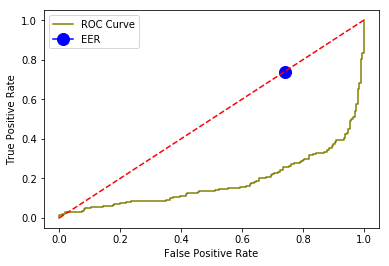

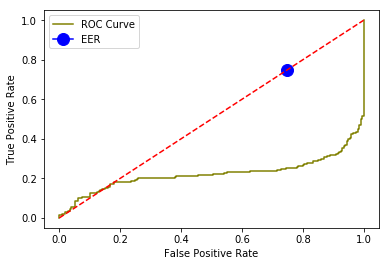

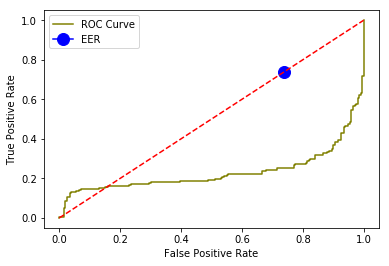

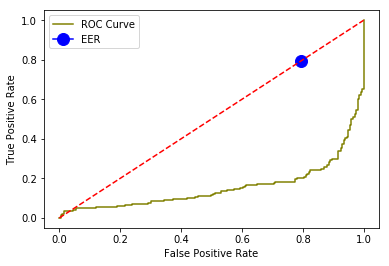

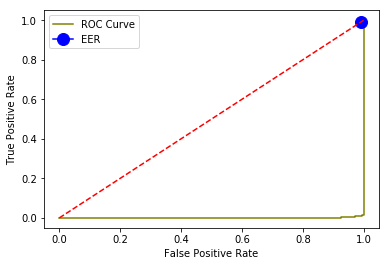

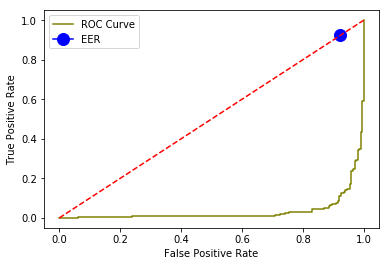

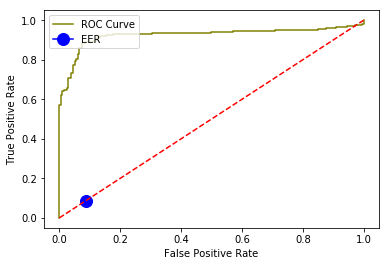

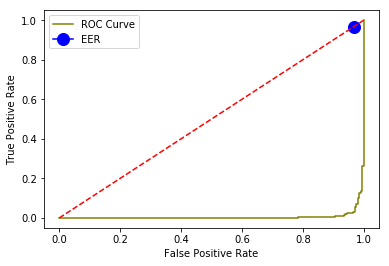

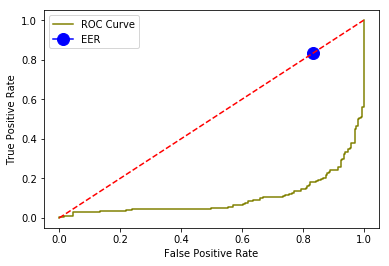

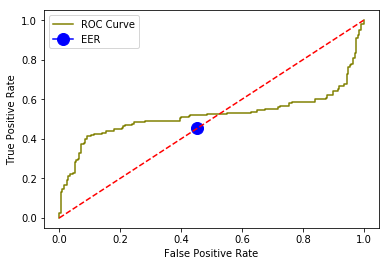

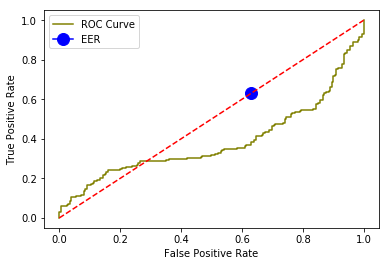

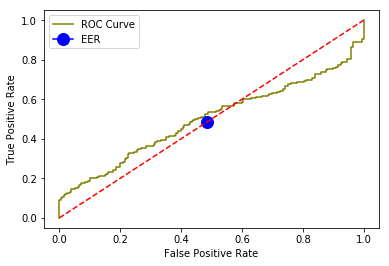

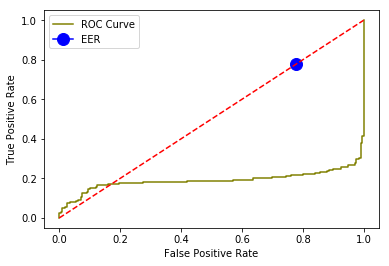

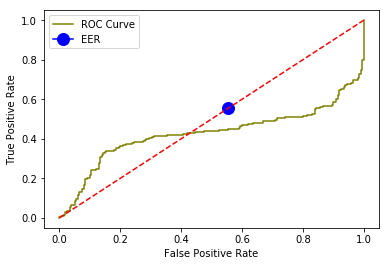

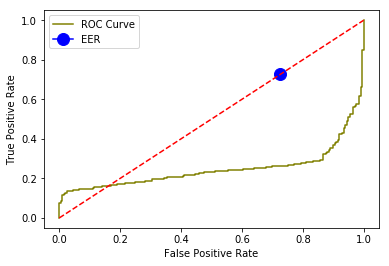

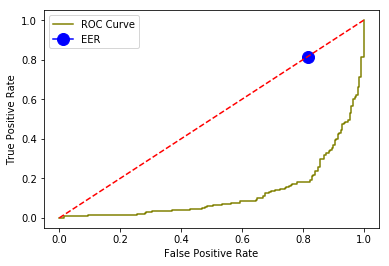

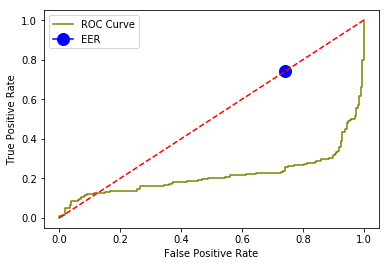

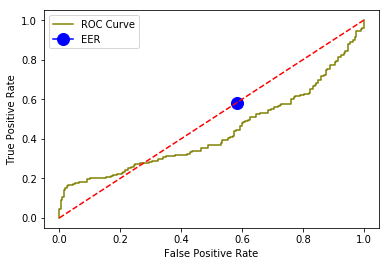

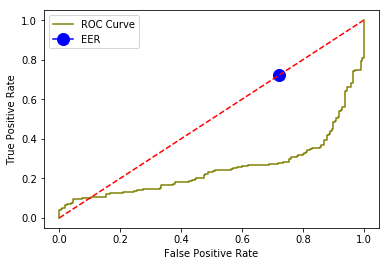

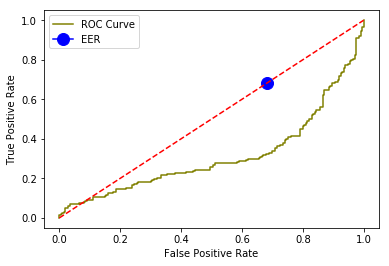

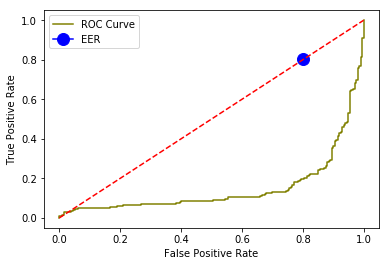

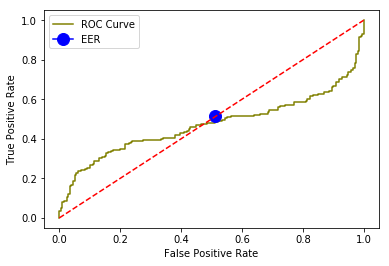

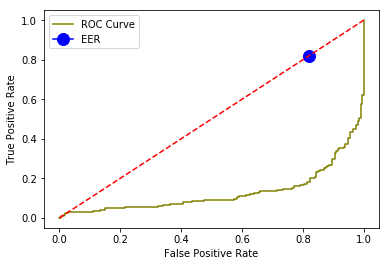

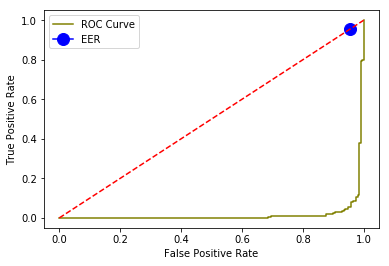

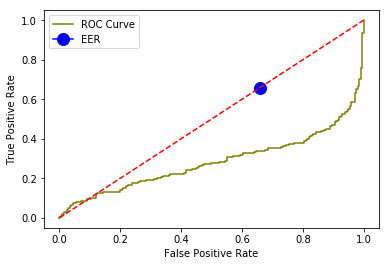

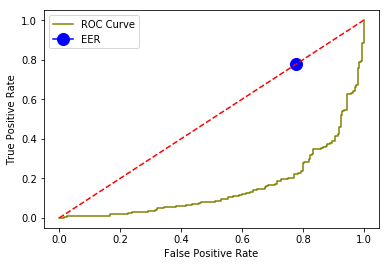

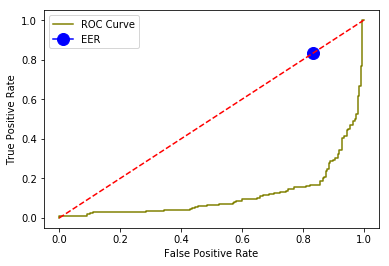

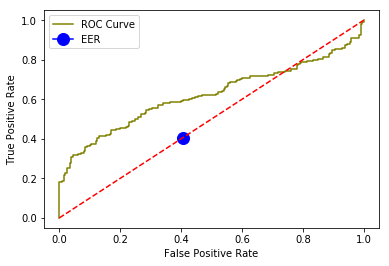

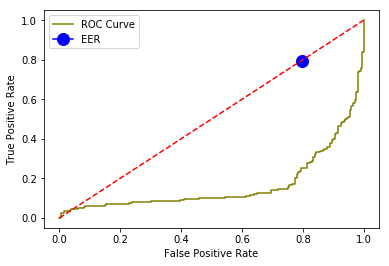

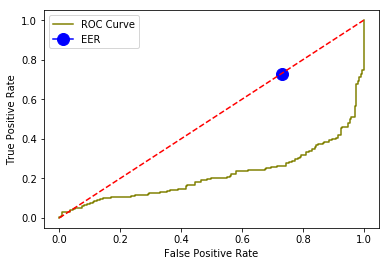

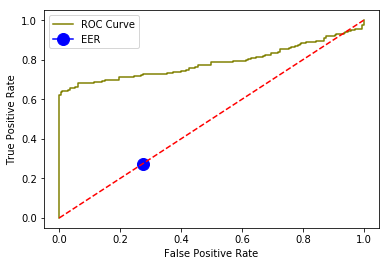

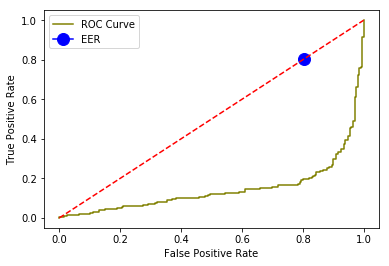

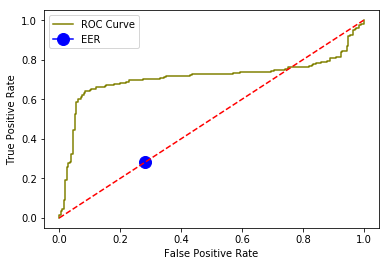

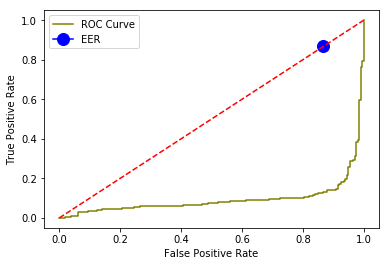

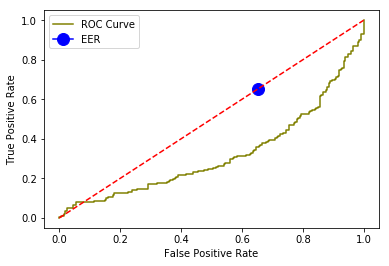

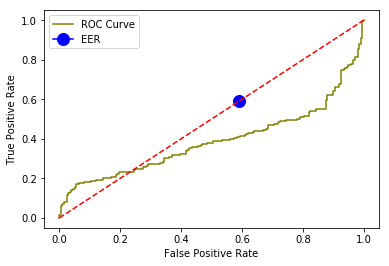

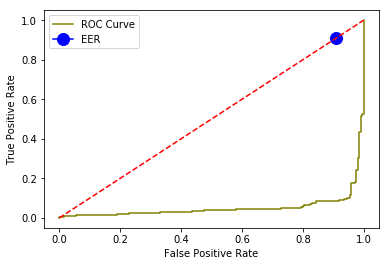

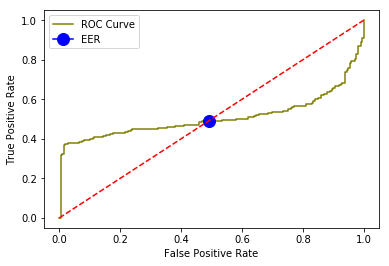

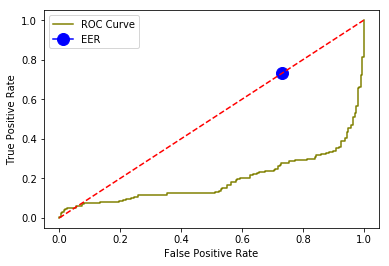

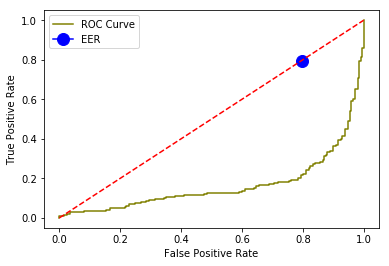

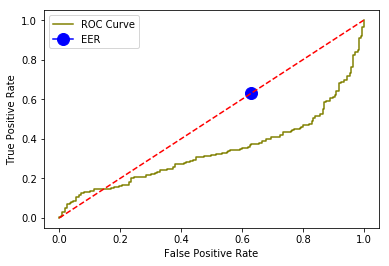

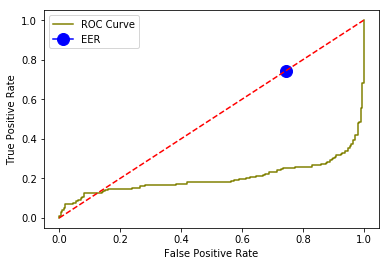

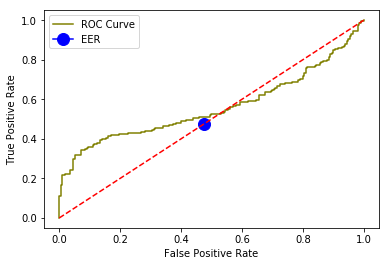

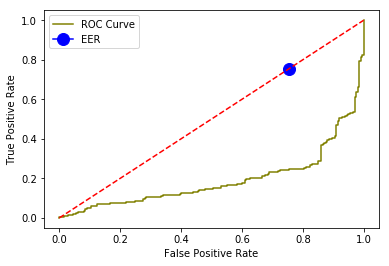

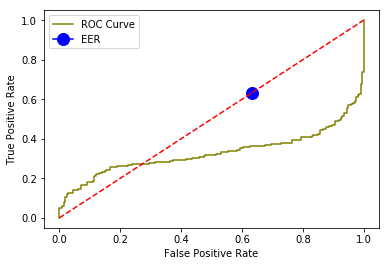

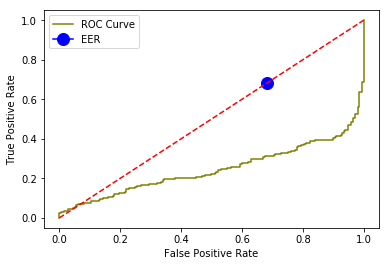

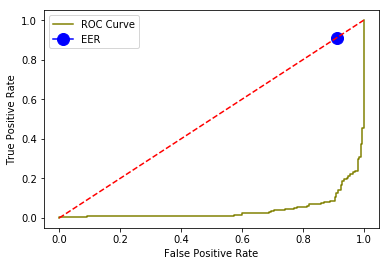

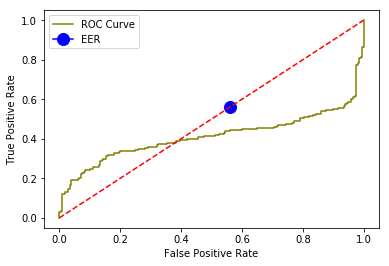

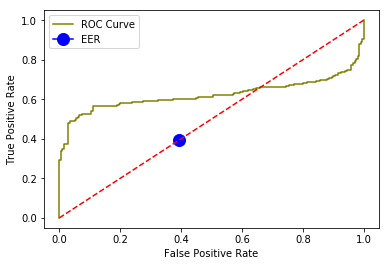

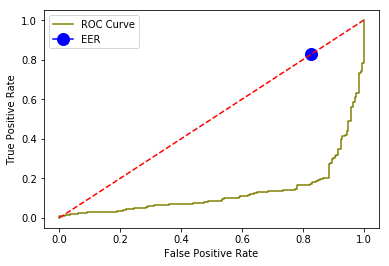

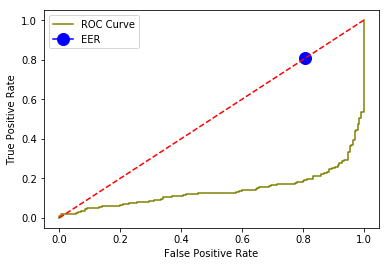

In [86]:
err_mean, err_std, errs = NeuralNetStandardDetector(subjects).evaluate()

In [87]:
err_mean, err_std

(0.6884493441557185, 0.18700545317104883)

### Neural Network (auto-assoc) Detector Hesaplanması

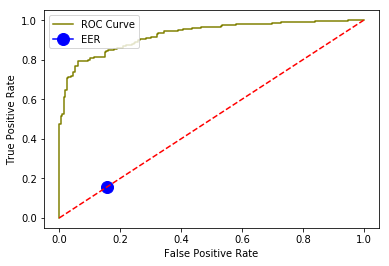

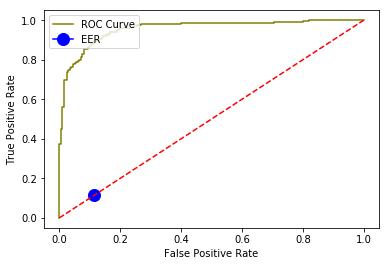

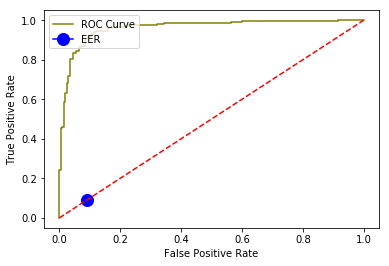

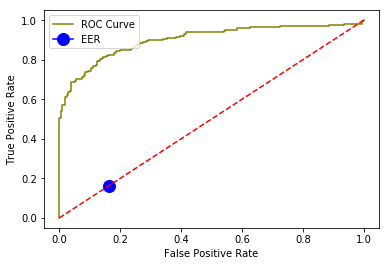

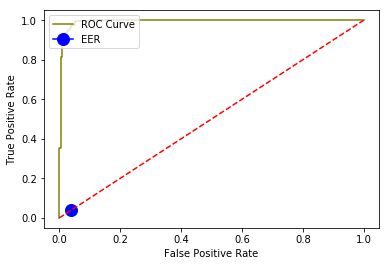

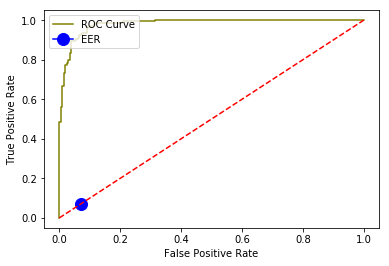

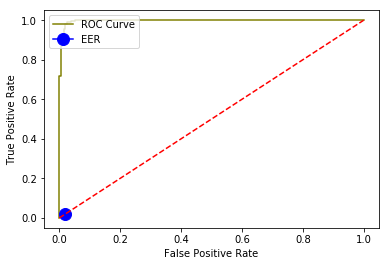

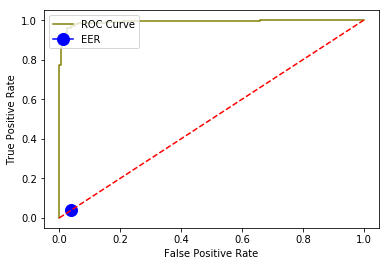

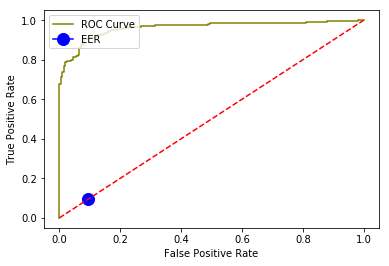

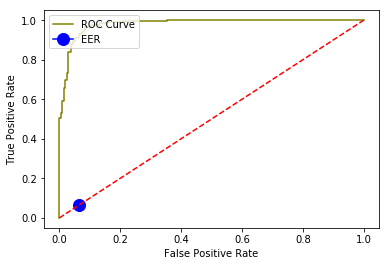

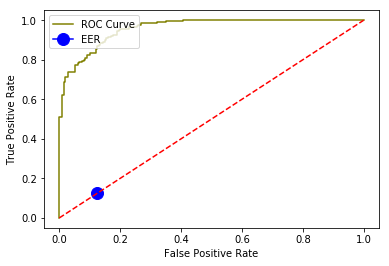

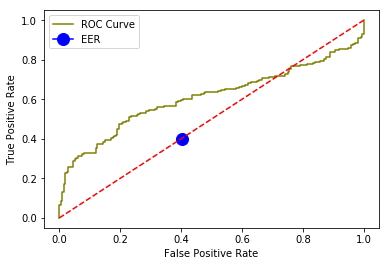

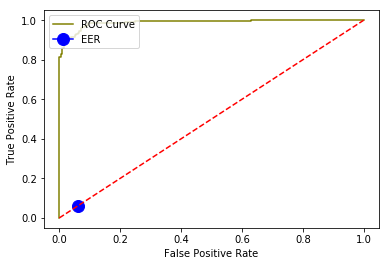

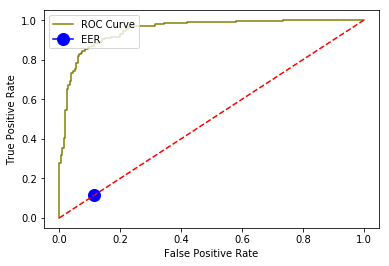

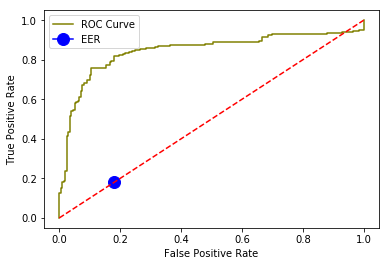

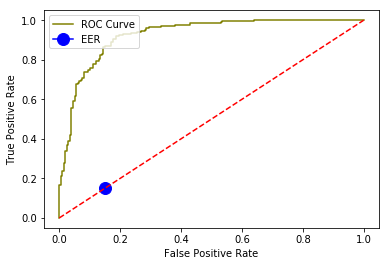

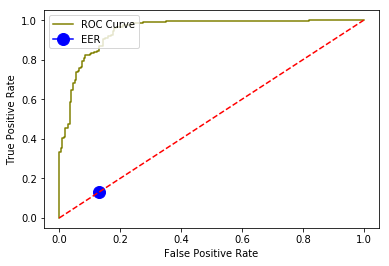

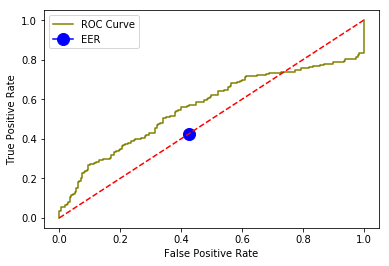

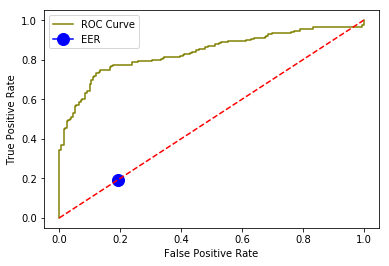

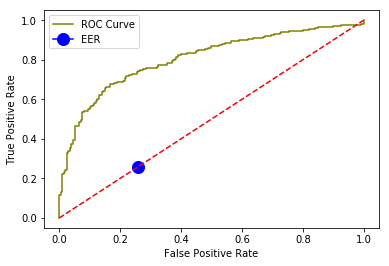

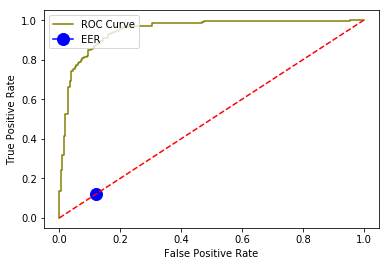

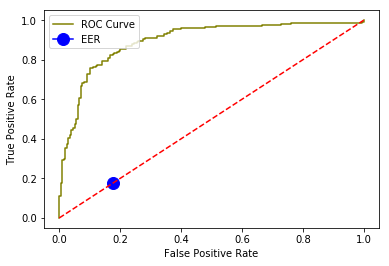

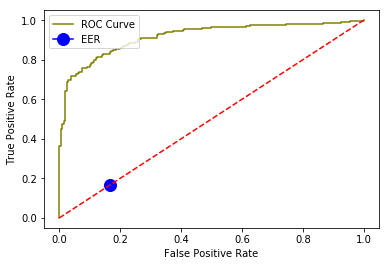

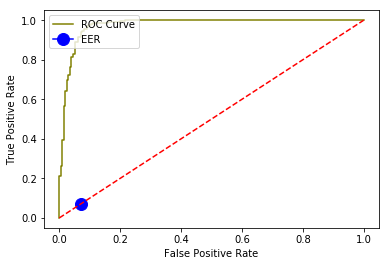

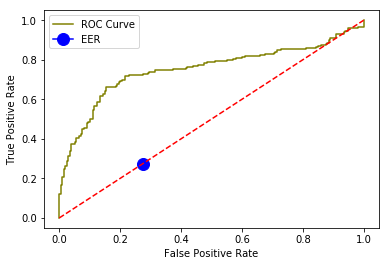

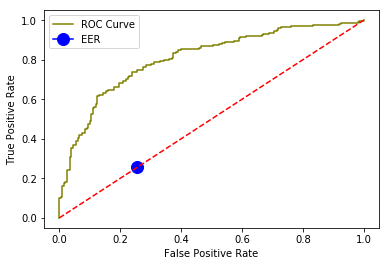

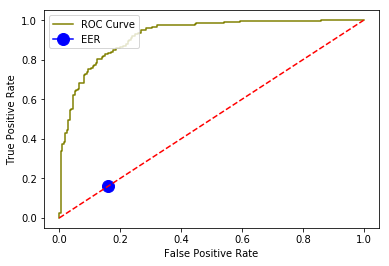

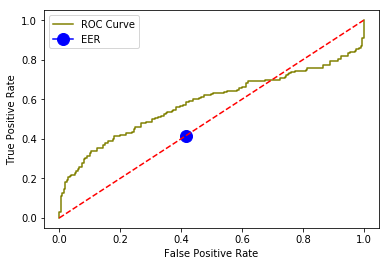

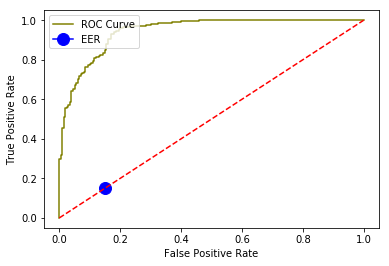

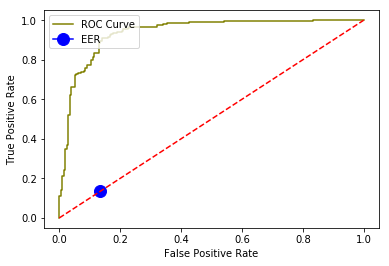

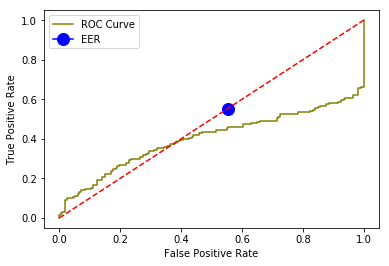

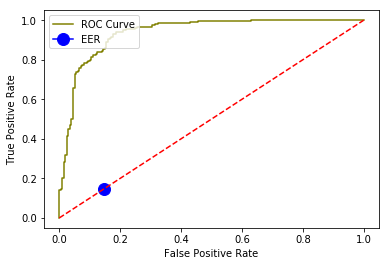

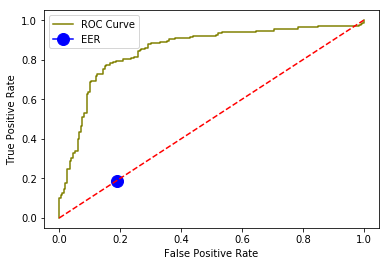

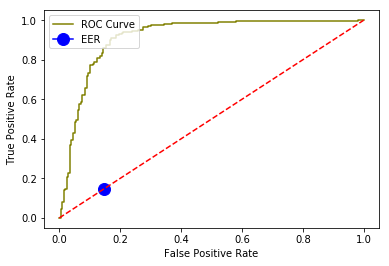

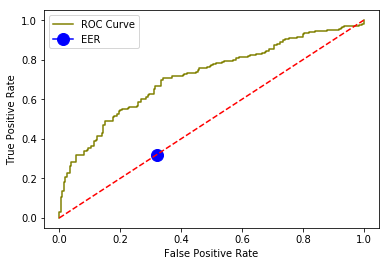

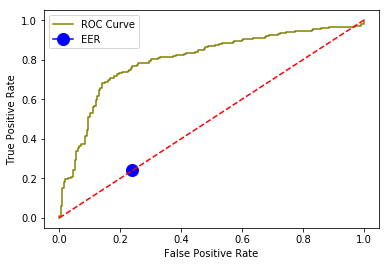

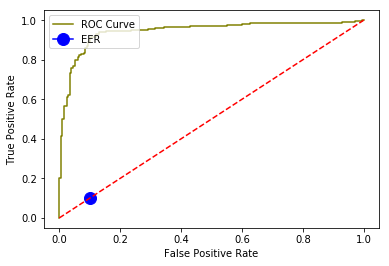

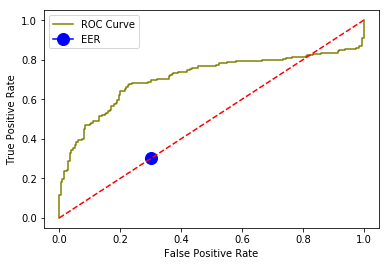

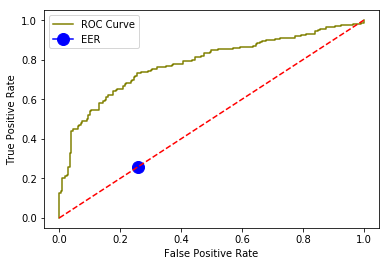

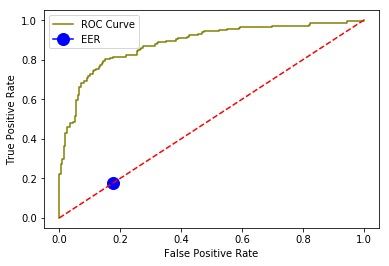

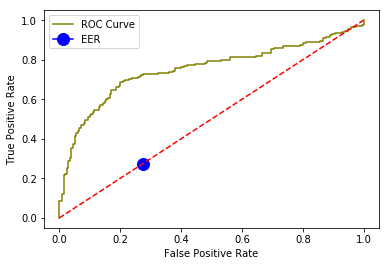

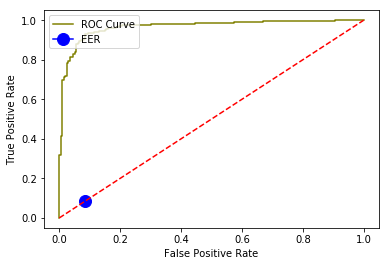

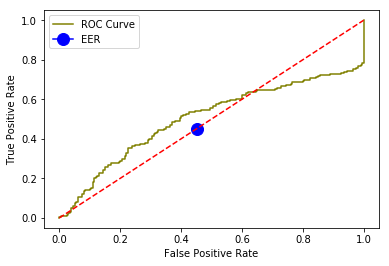

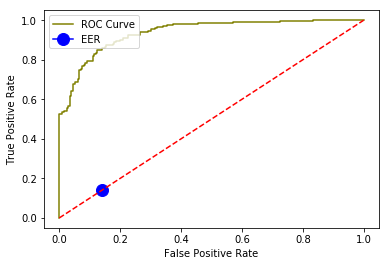

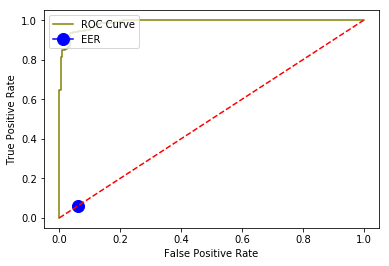

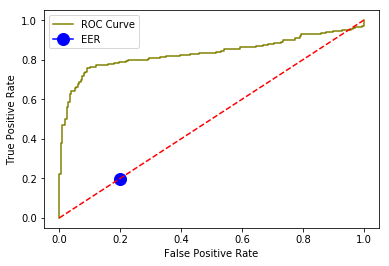

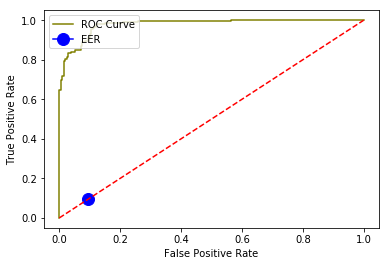

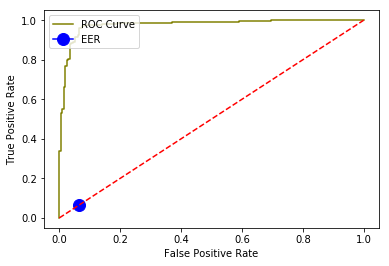

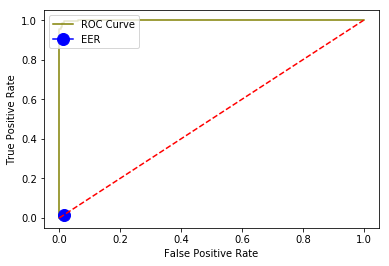

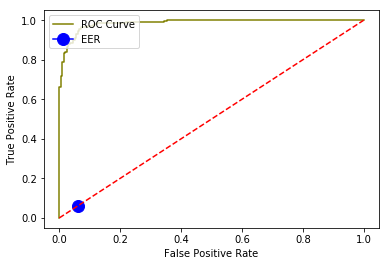

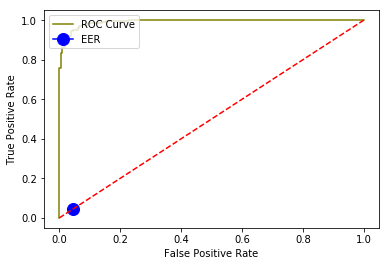

In [91]:
err_mean, err_std, errs = NeuralNetAutoAssocDetector(subjects).evaluate()

In [94]:
err_mean, err_std

(0.1715318654599048, 0.1185912827775858)

### Euclidean Detector Hesaplanması

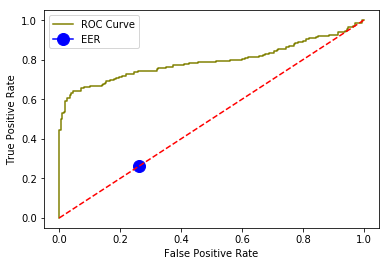

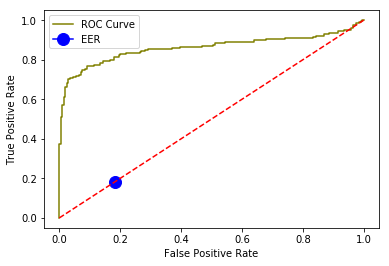

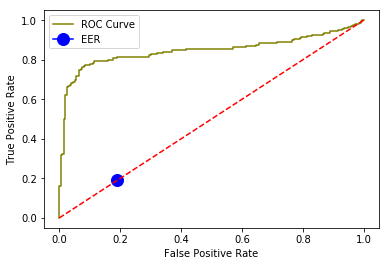

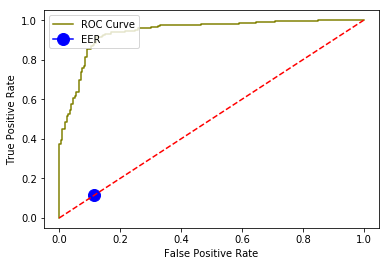

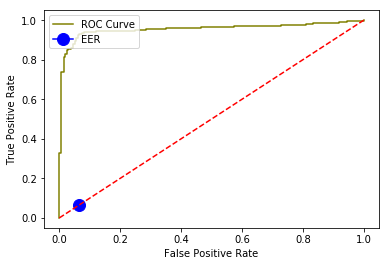

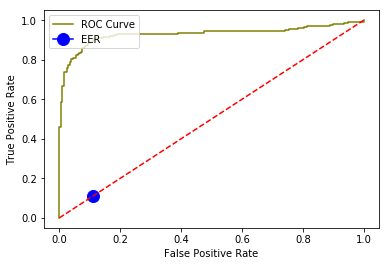

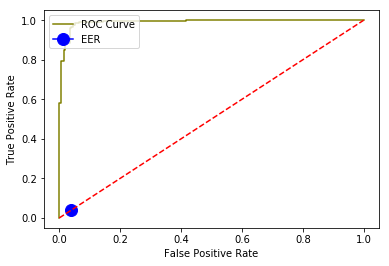

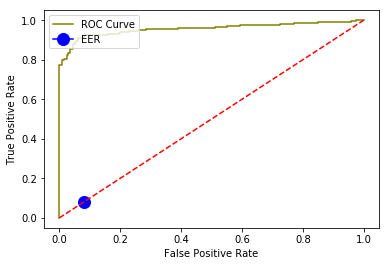

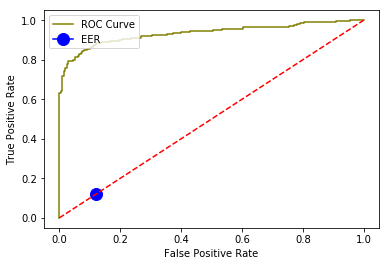

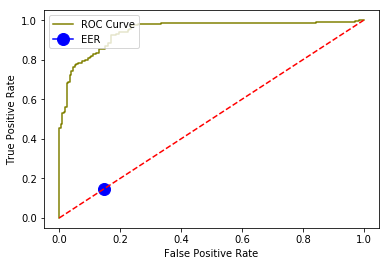

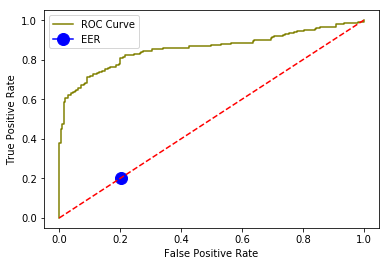

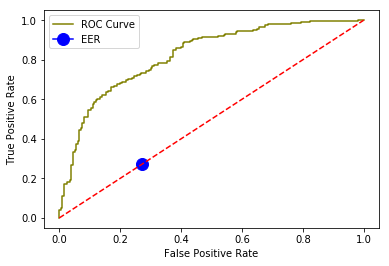

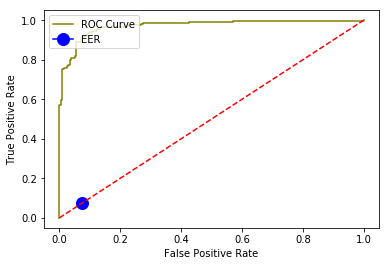

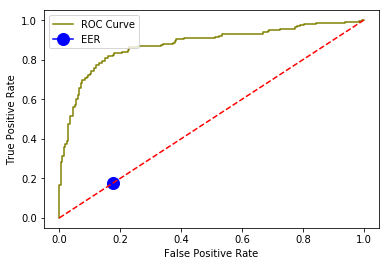

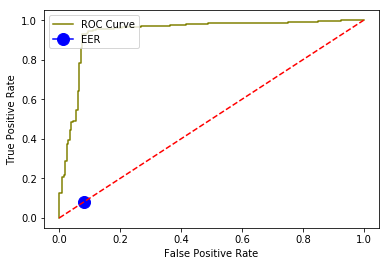

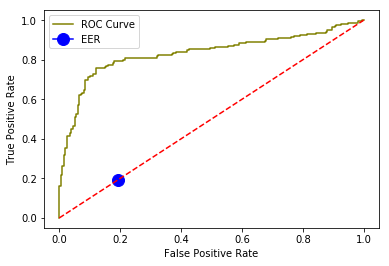

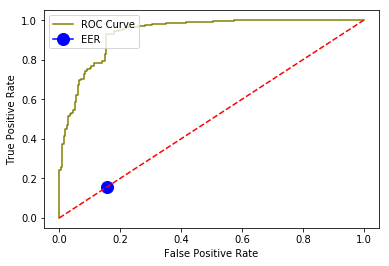

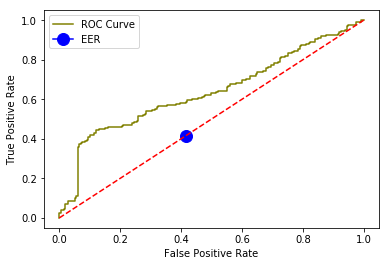

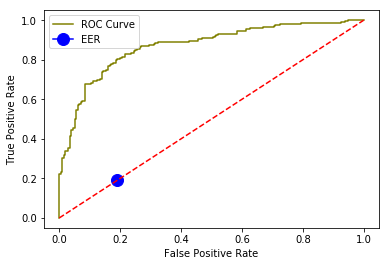

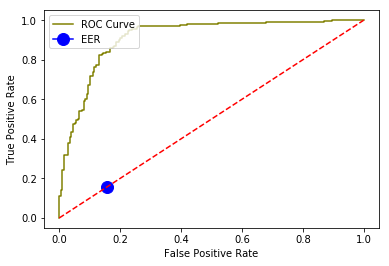

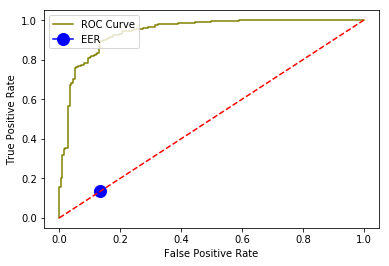

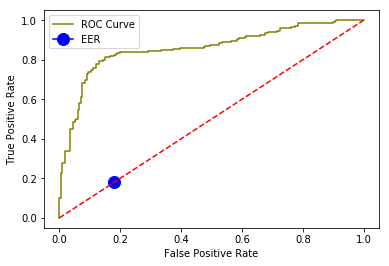

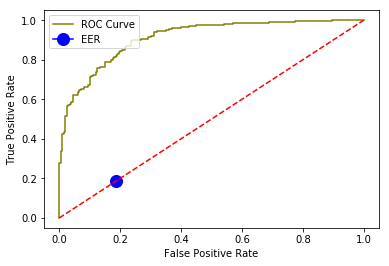

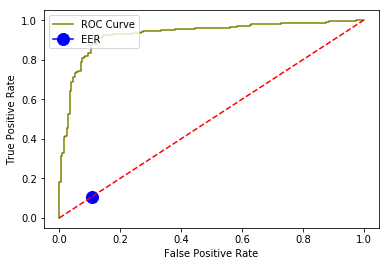

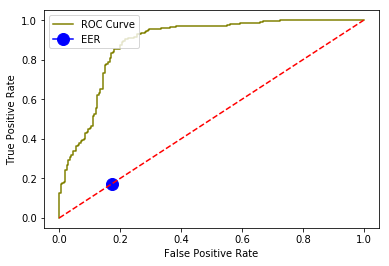

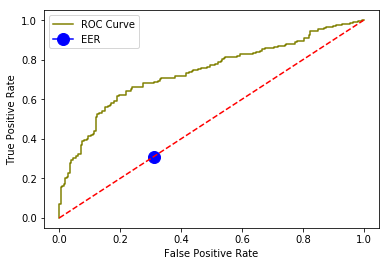

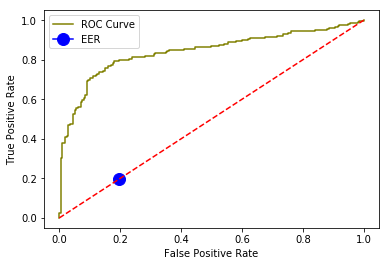

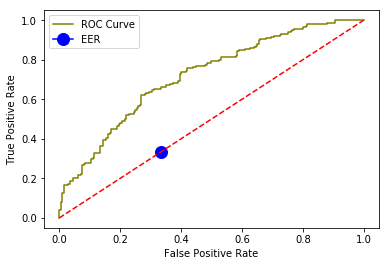

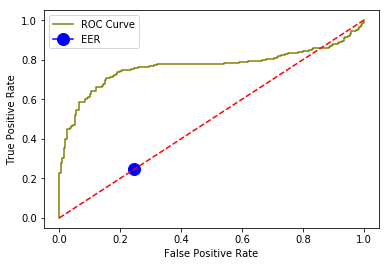

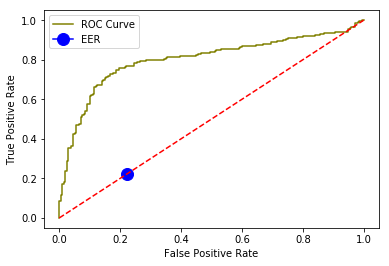

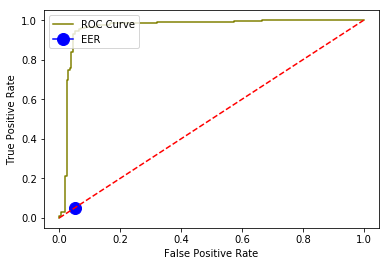

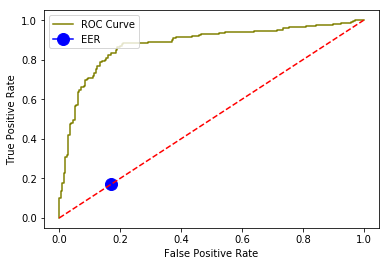

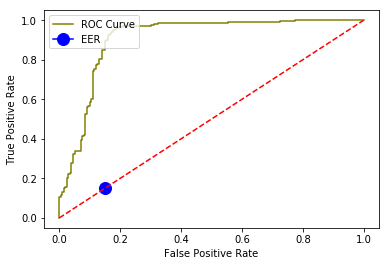

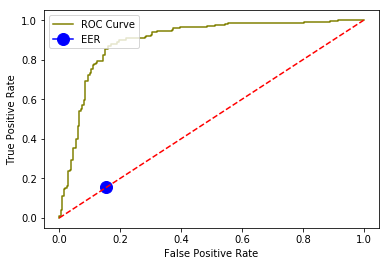

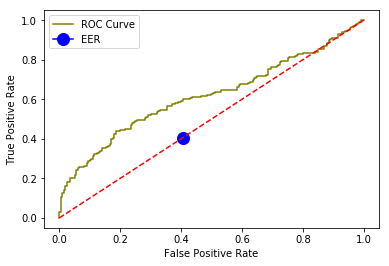

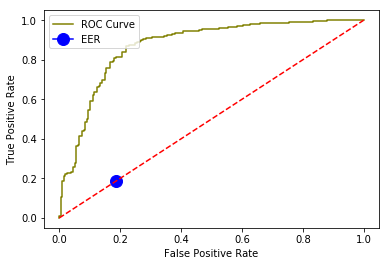

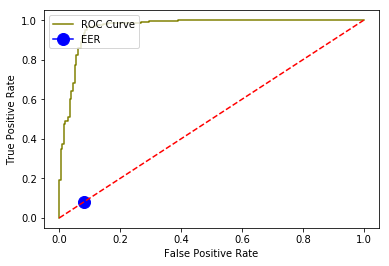

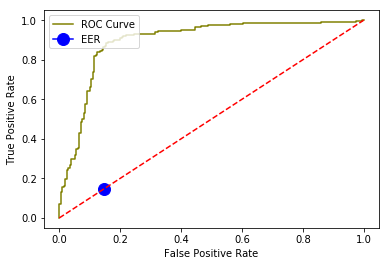

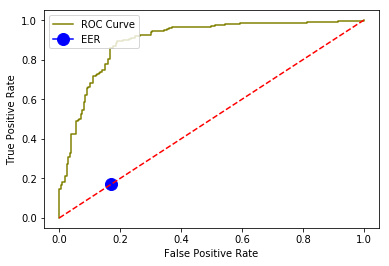

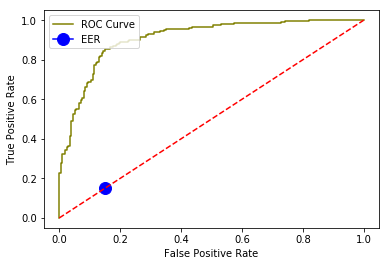

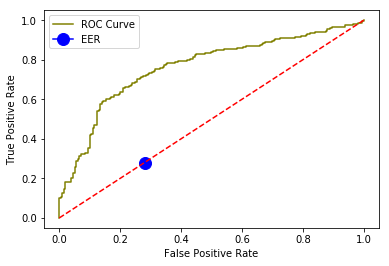

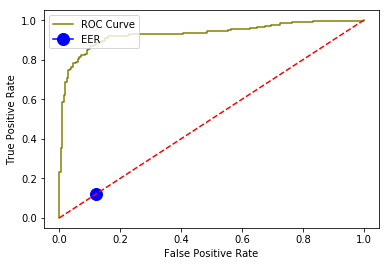

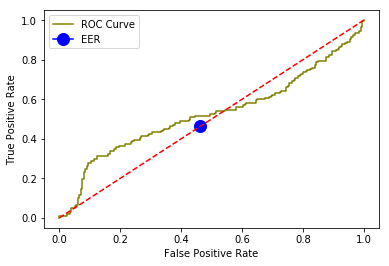

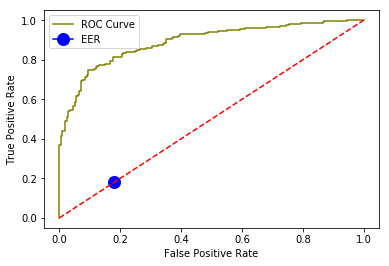

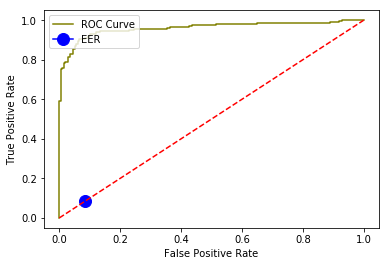

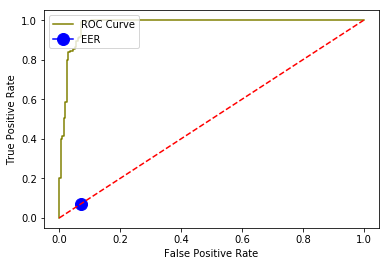

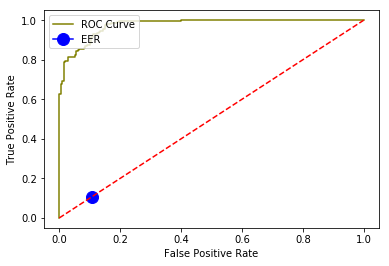

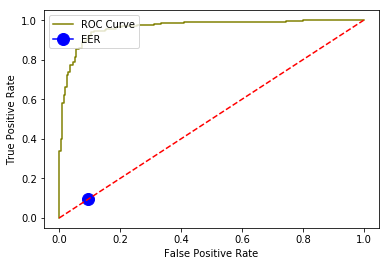

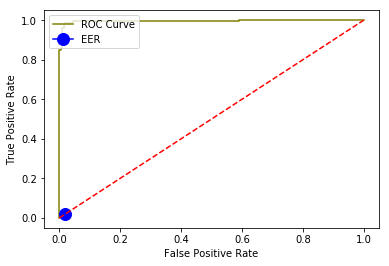

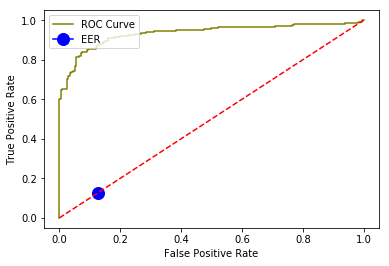

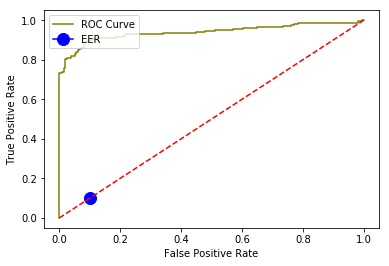

In [101]:
err_mean, err_std, errs = EuclideanDetector(subjects).evaluate()

In [102]:
err_mean, err_std

(0.16928649036431045, 0.09313837450860046)

### Manhattan Detector Hesaplanması

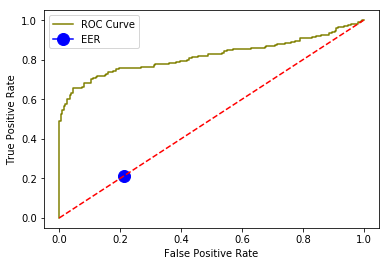

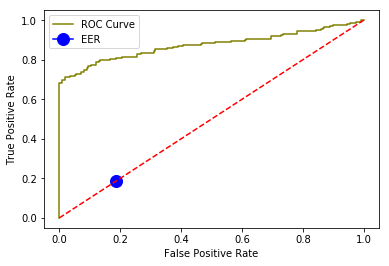

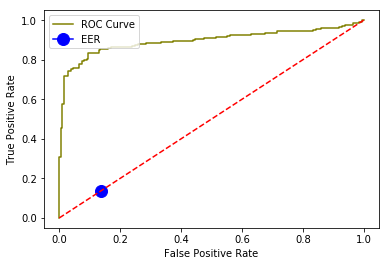

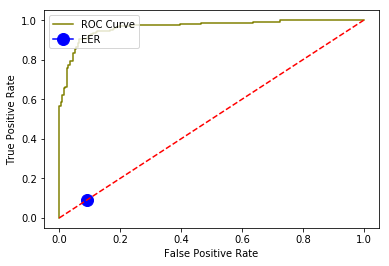

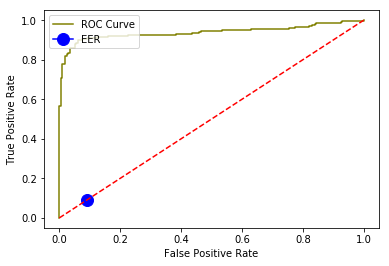

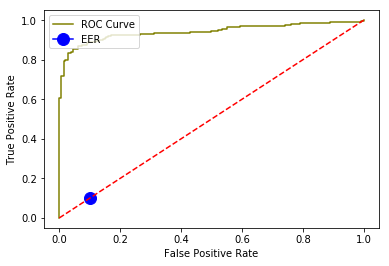

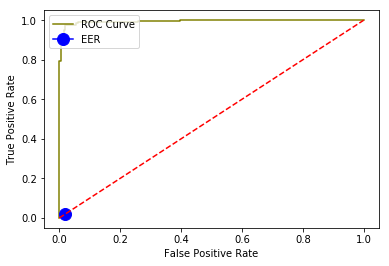

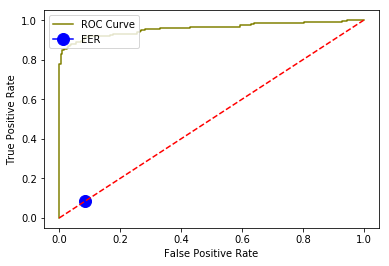

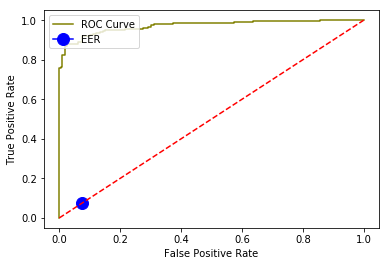

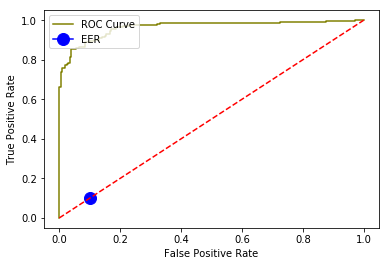

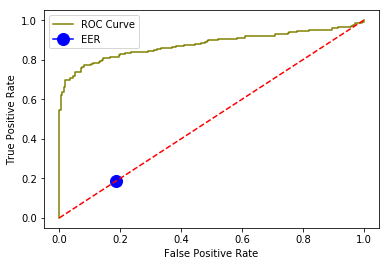

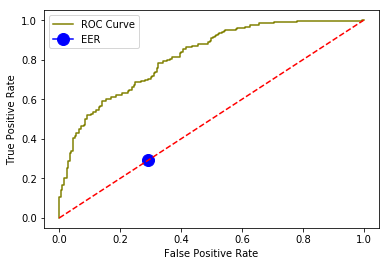

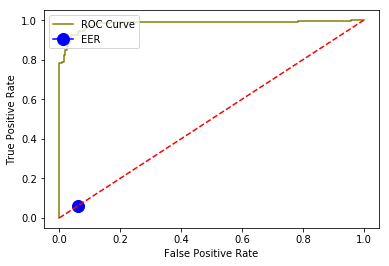

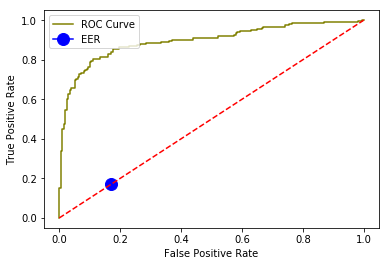

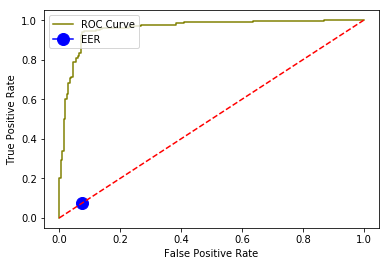

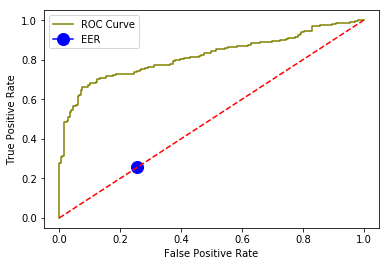

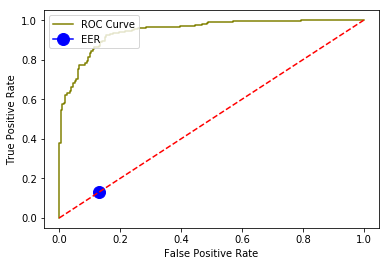

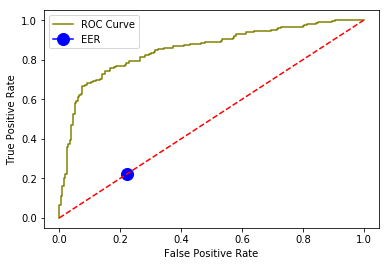

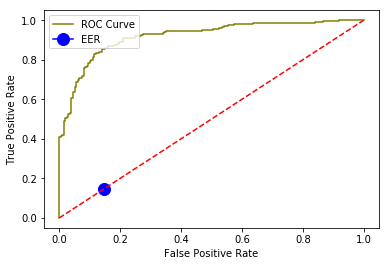

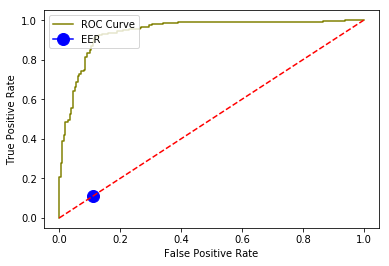

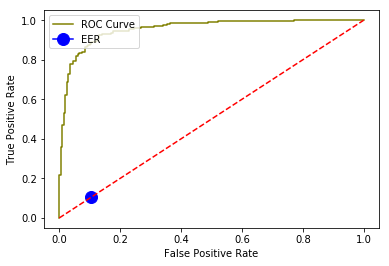

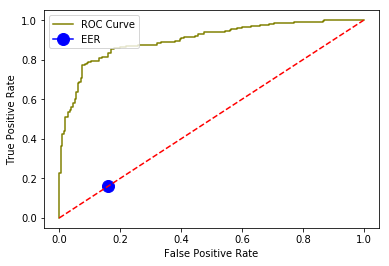

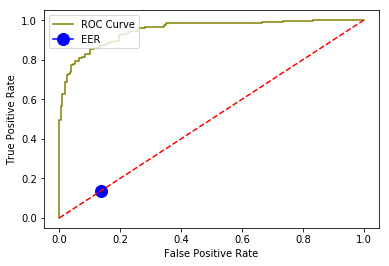

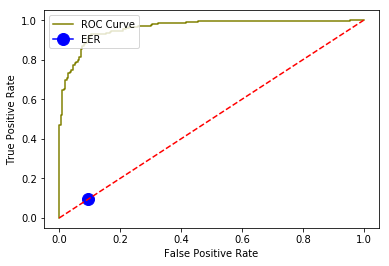

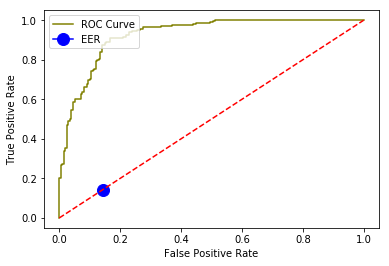

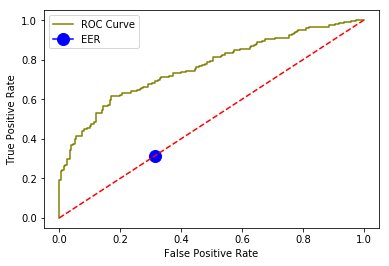

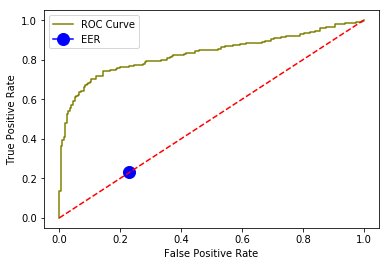

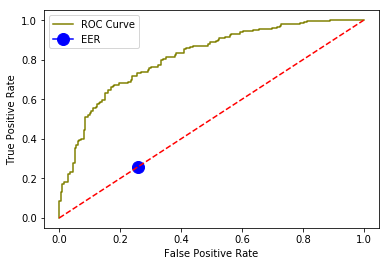

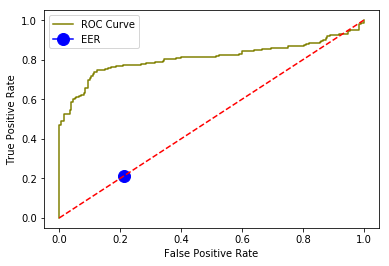

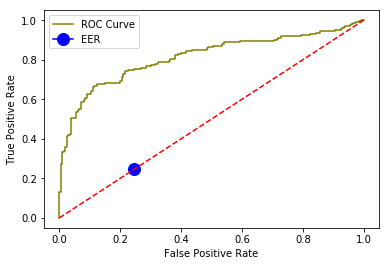

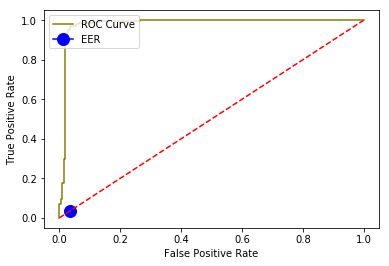

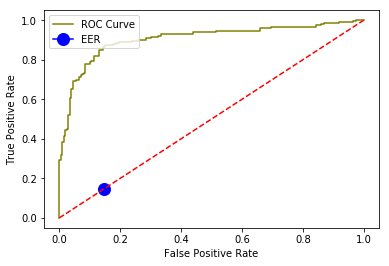

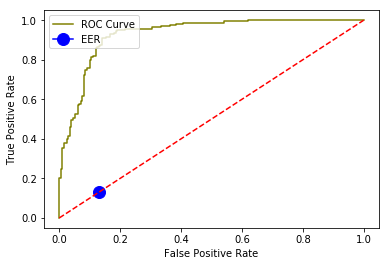

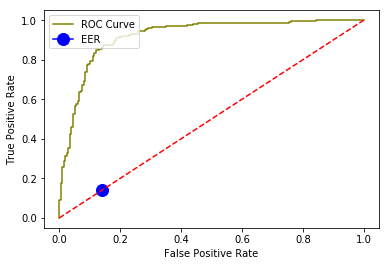

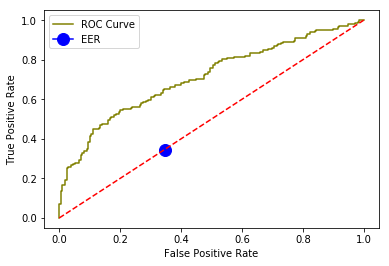

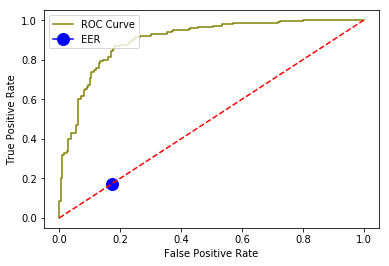

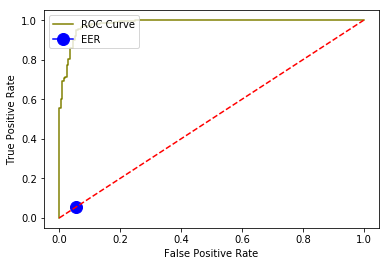

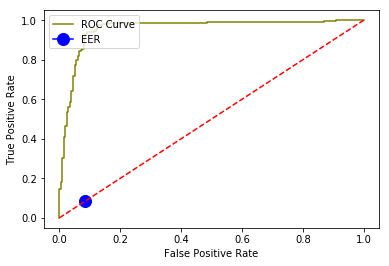

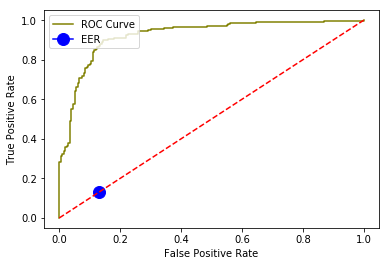

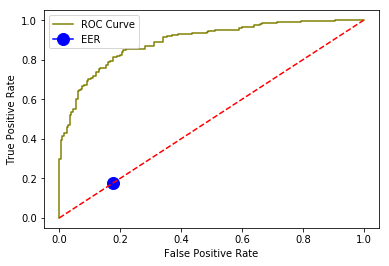

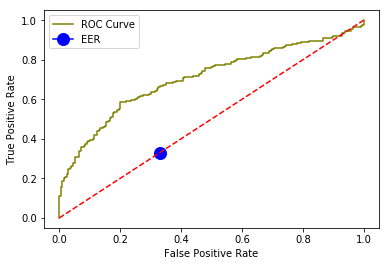

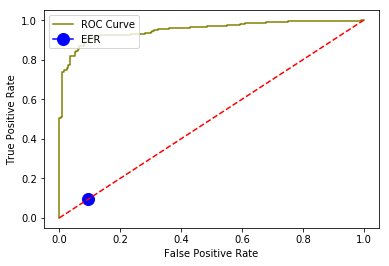

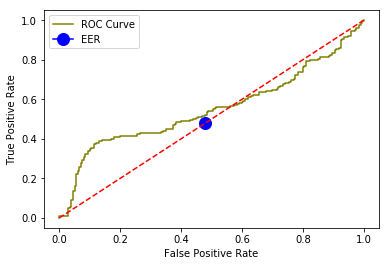

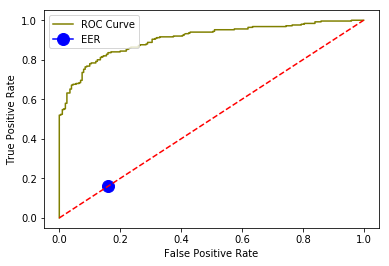

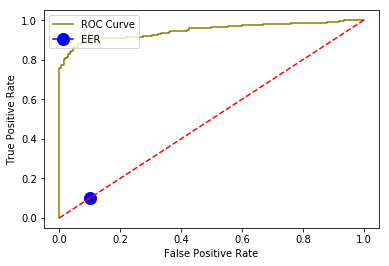

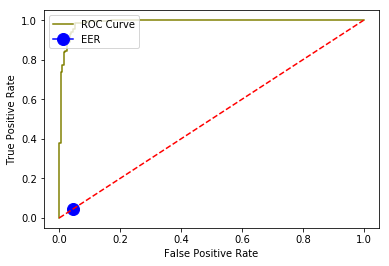

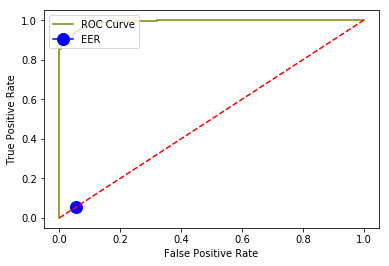

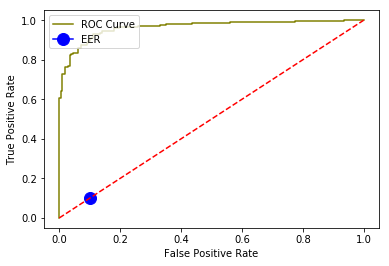

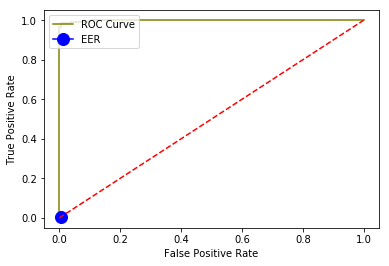

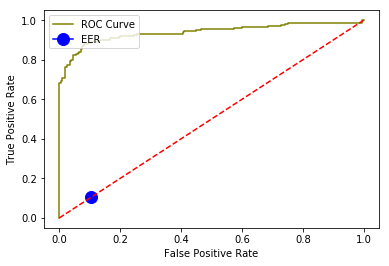

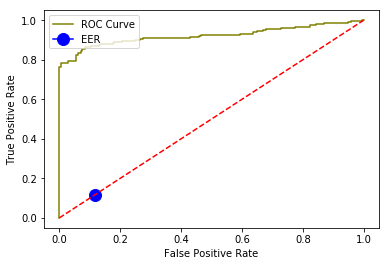

In [104]:
err_mean, err_std, errs = ManhattanDetector(subjects).evaluate()

In [105]:
err_mean, err_std

(0.15026997944690795, 0.09094241735620097)